
# Classification Tutorial

This notebook provides a reusable pipeline for classification tasks:
- Load any CSV file
- Manually set the target column
- Preprocessing with **LabelEncoder** (for categorical) and **StandardScaler** (for numeric)
- Train/Test split
- Training multiple models
- Evaluation with **classification report**, **confusion matrix**, and **ROC curve**



## 1) Imports

In [19]:

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, RocCurveDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
print('Ready!')


Ready!


## 2) Utility Functions

In [23]:
def load_data(path):
    """
    Load CSV file and display basic info.
    """
    df = pd.read_csv(path)
    print('Dataset shape:', df.shape)
    display(df.head())
    return df


def clean_data(df):
    """
    Clean dataset by removing duplicates and dropping fully empty rows.
    """
    before = df.shape[0]
    df = df.drop_duplicates()
    df = df.dropna(how='all')
    after = df.shape[0]
    print(f"Removed {before - after} duplicate/empty rows.")
    return df


def drop_columns(df, cols_to_drop):
    """
    Drop unwanted columns such as IDs or irrelevant features.
    """
    df = df.drop(columns=cols_to_drop, errors='ignore')
    print(f"Dropped columns: {cols_to_drop}")
    return df

def preprocess_data(df, target_col, encoding_method="label"):
    """
    Preprocess data:
    - Separate X and y
    - Encode categorical features (supports LabelEncoder, OneHotEncoder, OrdinalEncoder)
    - Encode target with LabelEncoder if categorical (and show mapping)
    - Impute missing numeric values with median
    - Scale numeric features with StandardScaler

    Parameters
    ----------
    df : pandas.DataFrame
        Input dataset
    target_col : str
        Target column name
    encoding_method : str
        Encoding technique for categorical features: "label", "onehot", "ordinal"

    Returns
    -------
    X : pandas.DataFrame
        Preprocessed features
    y : pandas.Series or numpy.array
        Encoded target
    le_target : LabelEncoder or None
        LabelEncoder for target (if categorical)
    """
    assert target_col in df.columns, f"Target column '{target_col}' not found in dataset."
    X = df.drop(columns=[target_col]).copy()
    y = df[target_col].copy()

    # Handle categorical features in X
    cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
    if encoding_method == "label":
        for col in cat_cols:
            le = LabelEncoder()
            X[col] = le.fit_transform(X[col].astype(str))
        print("Encoding method for features: LabelEncoder ")

    elif encoding_method == "onehot":
        X = pd.get_dummies(X, columns=cat_cols, drop_first=True)
        print("Encoding method for features: OneHotEncoder (via pandas.get_dummies) ")

    elif encoding_method == "ordinal":
        oe = OrdinalEncoder()
        X[cat_cols] = oe.fit_transform(X[cat_cols].astype(str))
        print("Encoding method for features: OrdinalEncoder ")

    else:
        raise ValueError("encoding_method must be one of: 'label', 'onehot', 'ordinal'")

    # Encode target if categorical
    le_target = None
    if y.dtype == 'object' or str(y.dtype).startswith('category'):
        le_target = LabelEncoder()
        y = le_target.fit_transform(y.astype(str))
        mapping = dict(zip(le_target.classes_, le_target.transform(le_target.classes_)))
        print("Target encoded with LabelEncoder ")
        print("Target mapping:", mapping)

    # Impute missing numeric values
    imputer = SimpleImputer(strategy='median')
    X[X.columns] = imputer.fit_transform(X)

    # Scale numeric features
    scaler = StandardScaler()
    X[X.columns] = scaler.fit_transform(X)

    return X, y, le_target


def split_data(X, y, test_size=0.2):
    """
    Split dataset into train/test sets with stratification if possible.
    """
    return train_test_split(X, y, test_size=test_size, random_state=42,
                            stratify=y if len(np.unique(y)) > 1 else None)


def evaluate_model(name, model, X_test, y_test):
    """
    Evaluate a trained model with classification report,
    confusion matrix, and ROC curve.
    """
    y_pred = model.predict(X_test)
    print(f"\n=== Test Report: {name} ===")
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    fig = plt.figure()
    plt.imshow(cm, interpolation='nearest')
    plt.title(f'Confusion Matrix - {name}')
    plt.colorbar()
    tick_marks = np.arange(len(np.unique(y_test)))
    plt.xticks(tick_marks, np.unique(y_test), rotation=45)
    plt.yticks(tick_marks, np.unique(y_test))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     ha="center", va="center")
    plt.tight_layout()
    plt.show()

    # ROC Curve
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X_test)
    elif hasattr(model, "decision_function"):
        scores = model.decision_function(X_test)
        if scores.ndim == 1:
            scores = np.vstack([-scores, scores]).T
        exp_scores = np.exp(scores - scores.max(axis=1, keepdims=True))
        proba = exp_scores / exp_scores.sum(axis=1, keepdims=True)
    else:
        print("ROC not supported for this model.")
        return None

    RocCurveDisplay.from_predictions(
        y_true=y_test,
        y_pred=proba[:,1] if proba.shape[1]==2 else proba
    )
    plt.title(f'ROC Curve - {name}')
    plt.show()

def compare_models(models, X_train, y_train, X_test, y_test):
    """
    Train and evaluate multiple models, return results in a pandas DataFrame.
    Metrics: Accuracy, Precision, Recall, F1-score.
    """
    results = []

    for name, model in models.items():
        # Train
        model.fit(X_train, y_train)
        # Predict
        y_pred = model.predict(X_test)

        # Metrics
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

        results.append({
            "Model": name,
            "Accuracy": acc,
            "Precision": prec,
            "Recall": rec,
            "F1-Score": f1
        })

    results_df = pd.DataFrame(results).sort_values(by="F1-Score", ascending=False).reset_index(drop=True)
    display(results_df)
    return results_df

## 3) Run Full Pipeline

Dataset shape: (614, 13)


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


Removed 0 duplicate/empty rows.
Dropped columns: ['Loan_ID']
Encoding method for features: LabelEncoder 
Target encoded with LabelEncoder 
Target mapping: {'N': 0, 'Y': 1}

=== Test Report: Logistic Regression ===
              precision    recall  f1-score   support

           0       0.96      0.58      0.72        38
           1       0.84      0.99      0.91        85

    accuracy                           0.86       123
   macro avg       0.90      0.78      0.81       123
weighted avg       0.88      0.86      0.85       123



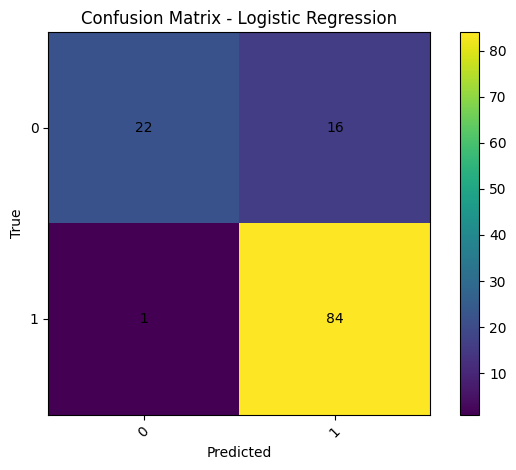

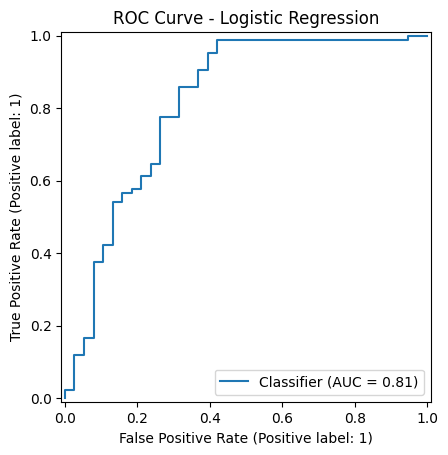


=== Test Report: K-Nearest Neighbors ===
              precision    recall  f1-score   support

           0       0.92      0.61      0.73        38
           1       0.85      0.98      0.91        85

    accuracy                           0.86       123
   macro avg       0.88      0.79      0.82       123
weighted avg       0.87      0.86      0.85       123



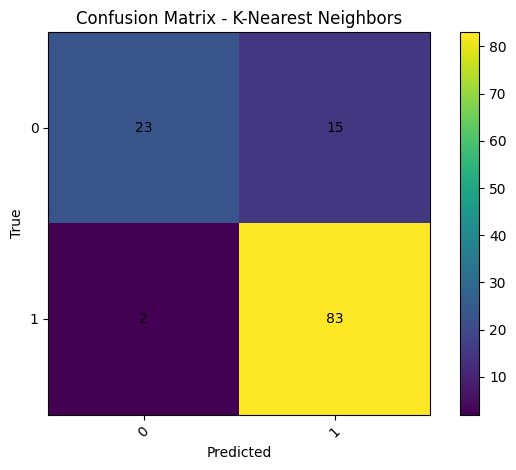

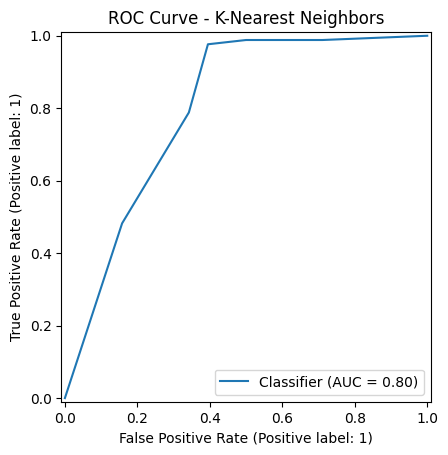


=== Test Report: Support Vector Machine ===
              precision    recall  f1-score   support

           0       0.95      0.53      0.68        38
           1       0.82      0.99      0.90        85

    accuracy                           0.85       123
   macro avg       0.89      0.76      0.79       123
weighted avg       0.86      0.85      0.83       123



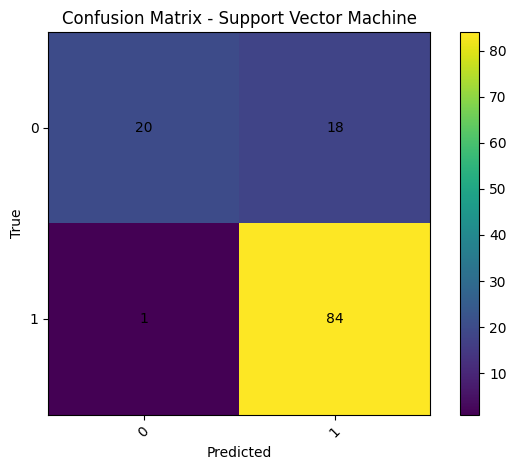

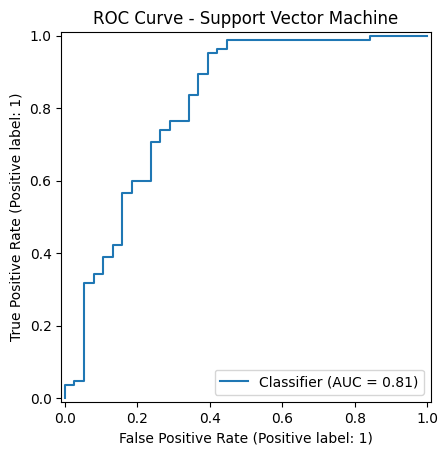


=== Test Report: Decision Tree ===
              precision    recall  f1-score   support

           0       0.56      0.58      0.57        38
           1       0.81      0.80      0.80        85

    accuracy                           0.73       123
   macro avg       0.69      0.69      0.69       123
weighted avg       0.73      0.73      0.73       123



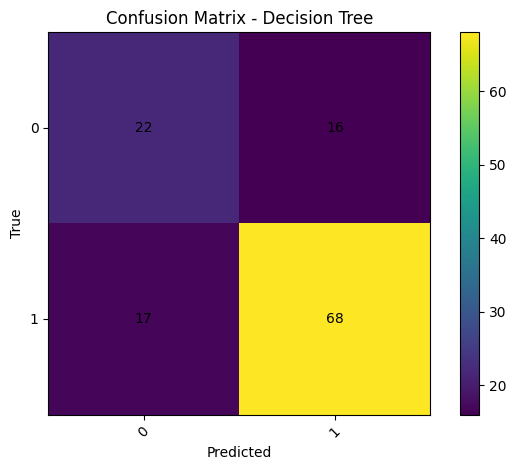

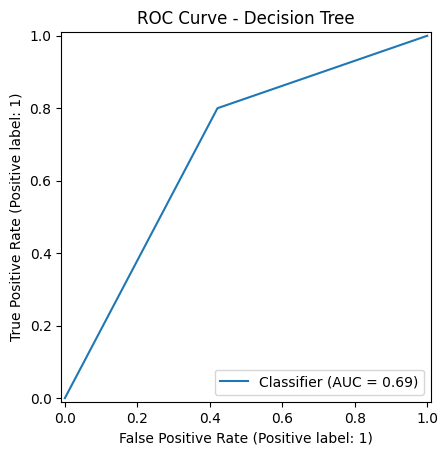


=== Test Report: Random Forest ===
              precision    recall  f1-score   support

           0       0.83      0.63      0.72        38
           1       0.85      0.94      0.89        85

    accuracy                           0.85       123
   macro avg       0.84      0.79      0.81       123
weighted avg       0.84      0.85      0.84       123



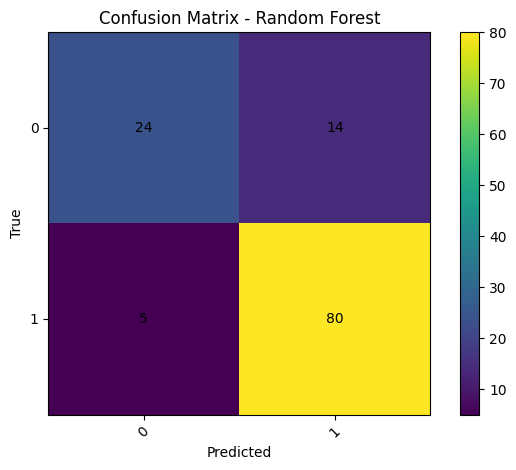

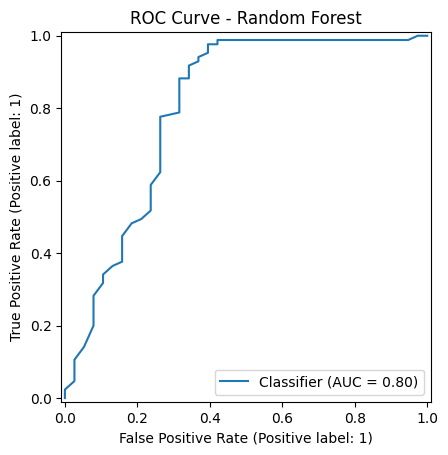


=== Test Report: Gradient Boosting ===
              precision    recall  f1-score   support

           0       0.84      0.55      0.67        38
           1       0.83      0.95      0.89        85

    accuracy                           0.83       123
   macro avg       0.83      0.75      0.78       123
weighted avg       0.83      0.83      0.82       123



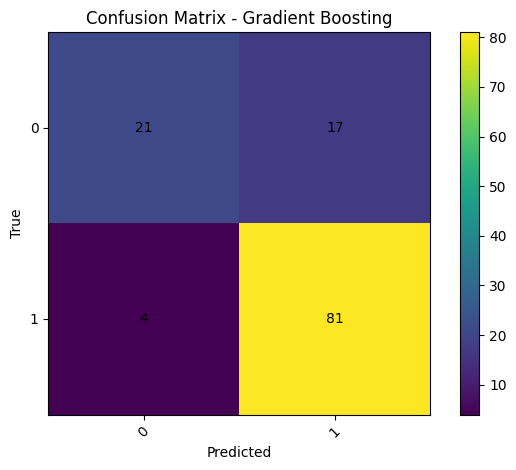

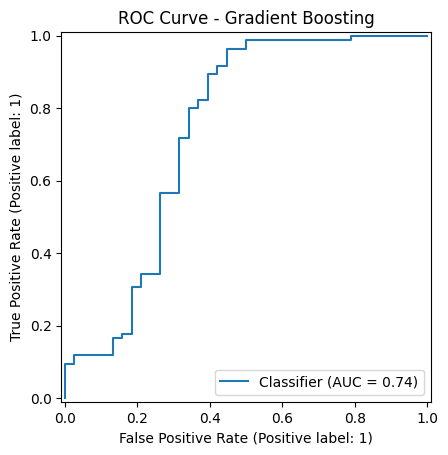

,Model,Accuracy,Precision,Recall,F1-Score
0,K-Nearest Neighbors,0.861789,0.869511,0.861789,0.852438
1,Logistic Regression,0.861789,0.875999,0.861789,0.850399
2,Support Vector Machine,0.845528,0.863337,0.845528,0.830296
3,Random Forest,0.829268,0.825078,0.829268,0.823984
4,Gradient Boosting,0.829268,0.830692,0.829268,0.817717
5,Decision Tree,0.723577,0.719715,0.723577,0.721449


In [24]:
# ==== Configuration ====
DATA_PATH = '../datasets/loan_predication/loan_predication.csv'
TARGET = 'Loan_Status'    # ⚠️ change to your target column
COLS_TO_DROP = ['Loan_ID']  # columns to drop if any
ENCODING_METHOD = "label"   # options: "label", "onehot", "ordinal"

# ==== Load Data ====
df = load_data(DATA_PATH)

# ==== Clean Data ====
df = clean_data(df)

# ==== Drop Unwanted Columns (if any) ====
df = drop_columns(df, COLS_TO_DROP)

# ==== Preprocess (with encoding choice) ====
X, y, le_target = preprocess_data(df, TARGET, encoding_method=ENCODING_METHOD)

# ==== Split Train/Test ====
X_train, X_test, y_train, y_test = split_data(X, y)

# ==== Define Models ====
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Support Vector Machine": SVC(probability=True),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier()
}

# ==== Train & Evaluate Each Model ====
for name, model in models.items():
    model.fit(X_train, y_train)
    evaluate_model(name, model, X_test, y_test)

# ==== Compare Models in One Table ====
results_table = compare_models(models, X_train, y_train, X_test, y_test)


In [22]:
# ==== Compare All Models in One Table ====
results_table = compare_models(models, X_train, y_train, X_test, y_test)


,Model,Accuracy,Precision,Recall,F1-Score
0,K-Nearest Neighbors,0.861789,0.869511,0.861789,0.852438
1,Logistic Regression,0.861789,0.875999,0.861789,0.850399
2,Support Vector Machine,0.845528,0.863337,0.845528,0.830296
3,Random Forest,0.829268,0.825078,0.829268,0.823984
4,Gradient Boosting,0.829268,0.830692,0.829268,0.817717
5,Decision Tree,0.691057,0.700492,0.691057,0.695058


In [29]:
import joblib

# ==== 1) Save trained models ====
def save_models(models, path="./saved_models"):
    """
    Save all trained models using joblib.
    """
    import os
    os.makedirs(path, exist_ok=True)
    for name, model in models.items():
        filename = f"{path}/{name.replace(' ', '_')}.joblib"
        joblib.dump(model, filename)
        print(f" Saved: {filename}")


# ==== 2) Load models ====
def load_models(path="./saved_models"):
    """
    Load all models previously saved with joblib.
    """
    import os
    loaded = {}
    for file in os.listdir(path):
        if file.endswith(".joblib"):
            model_name = file.replace("_", " ").replace(".joblib", "")
            loaded[model_name] = joblib.load(os.path.join(path, file))
    print(f" Loaded {len(loaded)} models from {path}")
    return loaded


# ==== 3) Prepare unseen data and test models ====
def test_on_unseen(unseen_path, target_col, models, cols_to_drop="Load_ID", encoding_method="label"):
    """
    Preprocess unseen dataset and evaluate each model on it.
    Also returns a comparison table with Accuracy, Precision, Recall, F1-Score.
    """
    unseen_df = load_data(unseen_path)
    unseen_df = clean_data(unseen_df)
    if cols_to_drop:
        unseen_df = drop_columns(unseen_df, cols_to_drop)

    X_unseen, y_unseen, le_target_unseen = preprocess_data(
        unseen_df, target_col, encoding_method=encoding_method
    )

    # Evaluate each model individually
    for name, model in models.items():
        evaluate_model(name, model, X_unseen, y_unseen)

    # Compare all models in one table
    results_unseen = compare_models(models, X_unseen, y_unseen, X_unseen, y_unseen)
    return results_unseen



 Saved: ./saved_models/Logistic_Regression.joblib
 Saved: ./saved_models/K-Nearest_Neighbors.joblib
 Saved: ./saved_models/Support_Vector_Machine.joblib
 Saved: ./saved_models/Decision_Tree.joblib
 Saved: ./saved_models/Random_Forest.joblib
 Saved: ./saved_models/Gradient_Boosting.joblib
 Loaded 6 models from ./saved_models
Dataset shape: (123, 13)


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP002898,Male,Yes,1,Graduate,No,1880,0.0,61.0,360.0,NaN,Rural,N
1,LP001027,Male,Yes,2,Graduate,NaN,2500,1840.0,109.0,360.0,1.0,Urban,Y
2,LP002422,Male,No,1,Graduate,No,37719,0.0,152.0,360.0,1.0,Semiurban,Y
3,LP002418,Male,No,3+,Not Graduate,No,4707,1993.0,148.0,360.0,1.0,Semiurban,Y
4,LP001882,Male,Yes,3+,Graduate,No,4333,1811.0,160.0,360.0,0.0,Urban,Y


Removed 0 duplicate/empty rows.
Dropped columns: ['Loan_ID']
Encoding method for features: LabelEncoder 
Target encoded with LabelEncoder 
Target mapping: {'N': 0, 'Y': 1}

=== Test Report: Decision Tree ===
              precision    recall  f1-score   support

           0       0.71      0.71      0.71        42
           1       0.85      0.85      0.85        81

    accuracy                           0.80       123
   macro avg       0.78      0.78      0.78       123
weighted avg       0.80      0.80      0.80       123



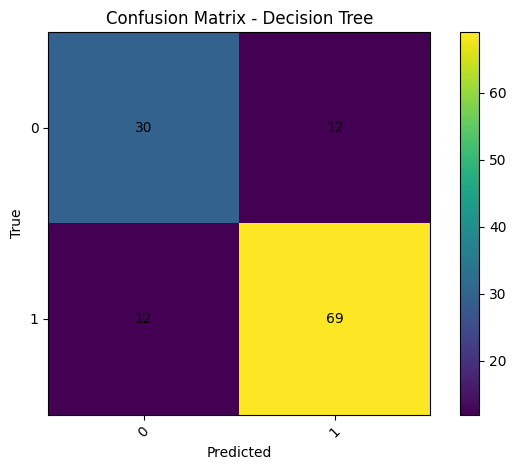

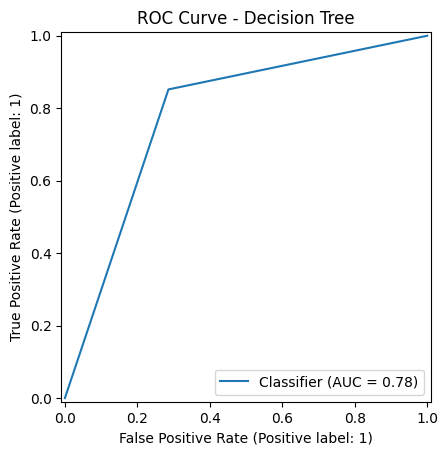


=== Test Report: Gradient Boosting ===
              precision    recall  f1-score   support

           0       0.90      0.62      0.73        42
           1       0.83      0.96      0.89        81

    accuracy                           0.85       123
   macro avg       0.86      0.79      0.81       123
weighted avg       0.85      0.85      0.84       123



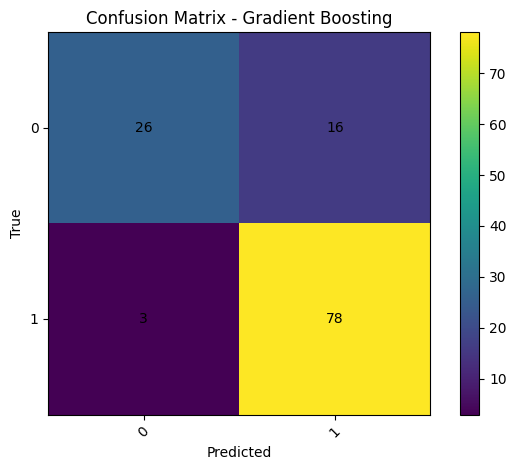

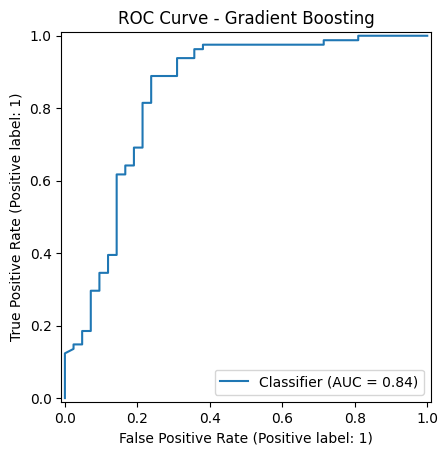


=== Test Report: K-Nearest Neighbors ===
              precision    recall  f1-score   support

           0       0.83      0.57      0.68        42
           1       0.81      0.94      0.87        81

    accuracy                           0.81       123
   macro avg       0.82      0.75      0.77       123
weighted avg       0.82      0.81      0.80       123



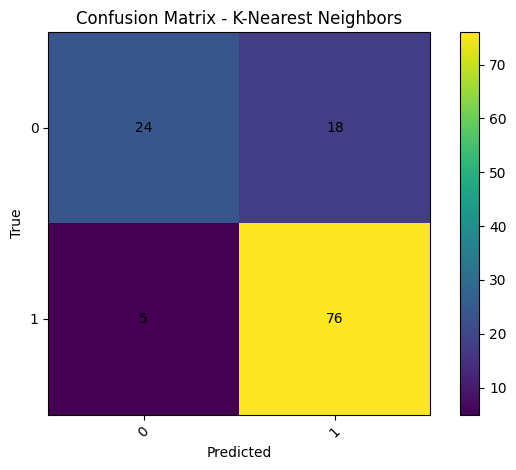

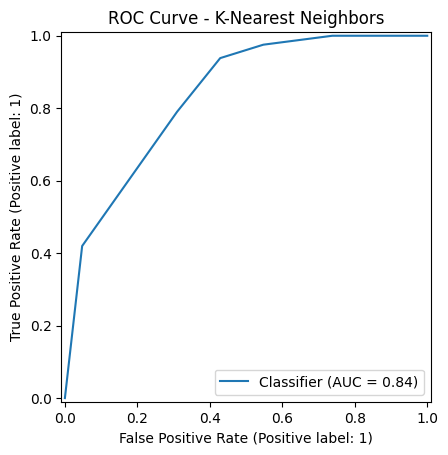


=== Test Report: Logistic Regression ===
              precision    recall  f1-score   support

           0       0.90      0.43      0.58        42
           1       0.77      0.98      0.86        81

    accuracy                           0.79       123
   macro avg       0.83      0.70      0.72       123
weighted avg       0.81      0.79      0.76       123



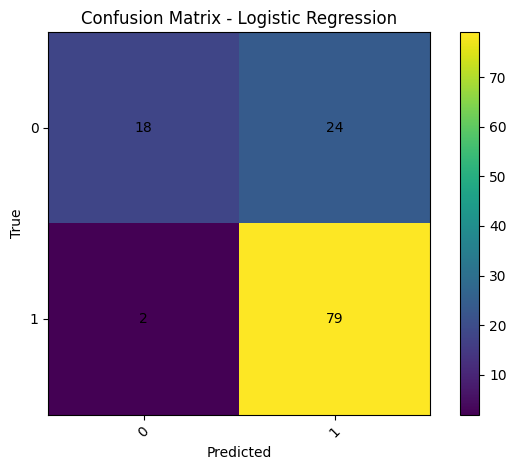

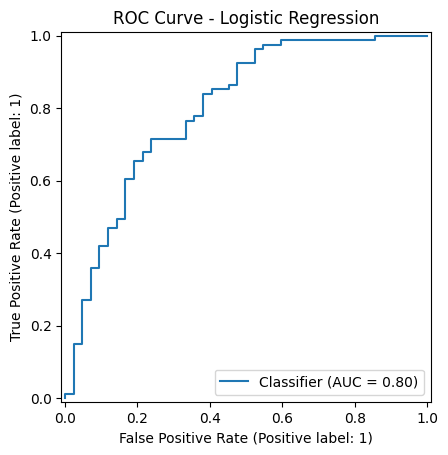


=== Test Report: Random Forest ===
              precision    recall  f1-score   support

           0       0.88      0.67      0.76        42
           1       0.85      0.95      0.90        81

    accuracy                           0.85       123
   macro avg       0.86      0.81      0.83       123
weighted avg       0.86      0.85      0.85       123



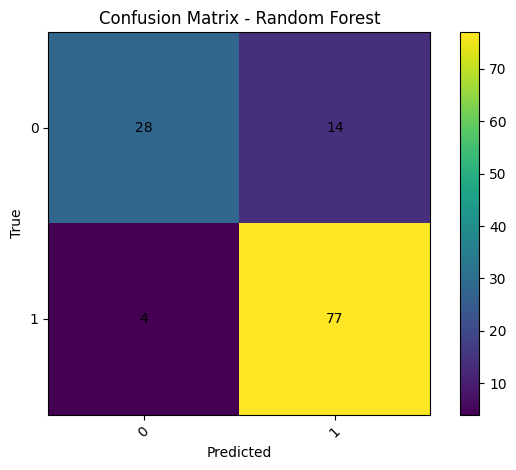

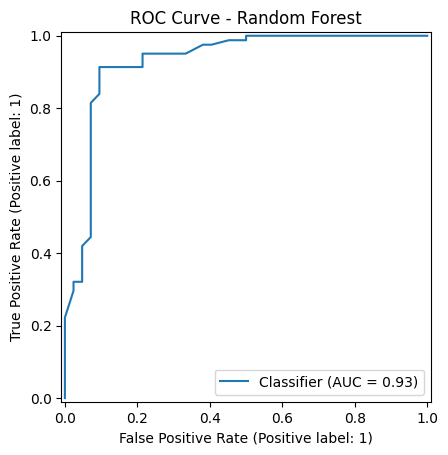


=== Test Report: Support Vector Machine ===
              precision    recall  f1-score   support

           0       0.91      0.48      0.62        42
           1       0.78      0.98      0.87        81

    accuracy                           0.80       123
   macro avg       0.85      0.73      0.75       123
weighted avg       0.83      0.80      0.79       123



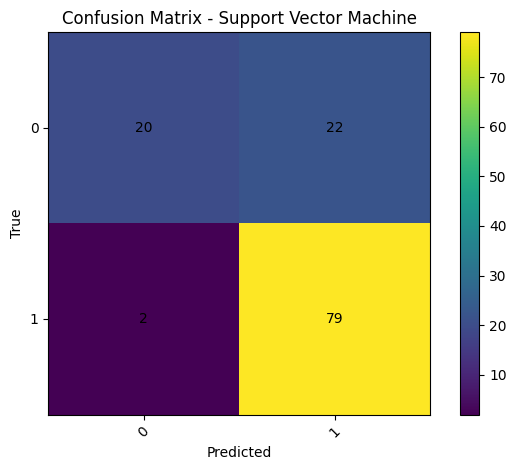

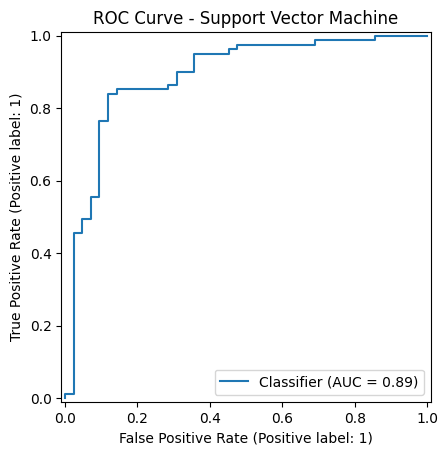

,Model,Accuracy,Precision,Recall,F1-Score
0,Decision Tree,1.000000,1.000000,1.000000,1.000000
1,Gradient Boosting,1.000000,1.000000,1.000000,1.000000
2,Random Forest,1.000000,1.000000,1.000000,1.000000
3,Support Vector Machine,0.861789,0.871365,0.861789,0.854269
4,K-Nearest Neighbors,0.821138,0.838507,0.821138,0.805691
5,Logistic Regression,0.813008,0.815024,0.813008,0.802835


In [30]:
# Save trained models
save_models(models)

# Load saved models
loaded_models = load_models()

# Test models on unseen dataset and get comparison table
unseen_path = "../datasets/loan_predication/loan_predication_unseen.csv"
results_unseen = test_on_unseen(
    unseen_path, TARGET, loaded_models, cols_to_drop=COLS_TO_DROP, encoding_method=ENCODING_METHOD
)
